In [797]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pandas
import tweetdf
import geopandas
import regions as rg
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import numpy as np
import importlib
from shapely.geometry import Polygon
import plotly.express as px
import plotly
importlib.reload(px)

<module 'plotly.express' from '/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/plotly/express/__init__.py'>

In [2]:
all_tweets = tweetdf.from_csv("../../dbs/Sweden.csv").dropna()

In [3]:
tweets = geopandas.GeoDataFrame(
    all_tweets,
    crs="EPSG:4326",
    geometry=geopandas.points_from_xy(all_tweets.longitude, all_tweets.latitude),
)

In [4]:
# Count number of tweets per user
tweets = tweets.merge(
    tweets.groupby('userid', as_index=False).count()[['userid', 'tweetid']].rename(columns={'tweetid': 'tweet_count'}),
    on='userid'
)

In [5]:
# Assign each user to a quantile based on number of tweets
# 9 is a empirically found value to produce evenly sized quantiles
tweets = tweets.assign(quantile=pandas.qcut(tweets['tweet_count'], q=9))

In [6]:
def cluster_tweets(df, eps_km=0.1, min_samples=1):
    kms_per_radian = 6371.0088
    coords = df[['latitude', 'longitude']].values
    return DBSCAN(eps=eps_km/kms_per_radian, min_samples=min_samples, metric='haversine').fit(np.radians(coords))

In [7]:
def cluster_spatial(tws, eps_km=0.1, min_samples=1):
    cls = cluster_tweets(tws, eps_km=eps_km, min_samples=min_samples)
    labels = pandas.Series(cls.labels_)
    return tws.assign(region=pandas.Series(cls.labels_, index=tws.index).values)

In [8]:
regions = tweets.groupby('userid', as_index=False).apply(cluster_spatial)

In [9]:
regions = regions.assign(label=np.full(shape=regions.shape[0], fill_value="other"))

In [545]:
def plot_label_distrib(region_df):
    region_df.groupby(['quantile', 'label']).size().unstack().fillna(0).plot(kind='barh', stacked=True, figsize=(15,7))

def plot_label_hourofday(region_df):
    region_df.groupby(['hourofday', 'label']).size().unstack().fillna(0).plot(kind='line', figsize=(15,7))

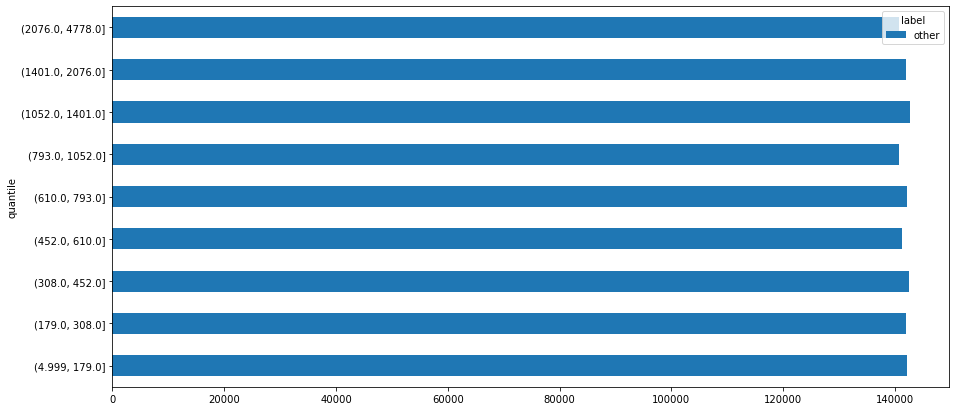

In [547]:
plot_label_distrib(regions)

In [19]:
def during_home(df):
    weekdays = (df['weekday'] < 6) & (0 < df['weekday'])
    weekends = (df['weekday'] == 6) | (0 == df['weekday'])
    morning_evening = (df['hourofday'] < 10) | (17 < df['hourofday'])
    return df[((weekdays) & (morning_evening)) | (weekends)]

def label_home(df):
    print("copying")
    dfc = df.copy(deep=True)
    print("reindex")
    dfc = dfc.set_index(['userid', 'region', 'tweetid']).sort_index()
    print("largest cluster")
    homeidx = during_home(dfc)\
        .groupby(['userid', 'region']).size() \
        .groupby('userid').nlargest(1) \
        .index.tolist()
    print(len(homeidx))
    print("set values")
    for (_, userid, regionid) in homeidx:
        dfc.loc[(userid, regionid), 'label'] = "home"
    return dfc

In [23]:
regions_home = label_home(regions)

copying
reindex
largest cluster
3480
set values


In [598]:
regions_home.loc[1723721].groupby('label').head()

createdat   latitude   longitude  \
region tweetid                                                                
0      165077186259324928  2012-02-02 15:20:43+01:00  59.337224   18.074058   
1      177683827882332160  2012-03-08 10:15:00+01:00  55.593921   13.013778   
       177687344135155713  2012-03-08 10:28:58+01:00  55.593809   13.013834   
       177690897411080192  2012-03-08 10:43:05+01:00  55.593838   13.014040   
2      180294871251292160  2012-03-15 15:10:21+01:00  59.337160   18.058205   
33     782315892336046080  2016-10-01 13:26:58-07:00  37.785920 -122.400740   
       782319740744118272  2016-10-01 13:42:15-07:00  37.785920 -122.400740   
       782323907793596416  2016-10-01 13:58:49-07:00  37.785920 -122.400740   
       782331267207483392  2016-10-01 14:28:03-07:00  37.785920 -122.400740   
       782340843512344579  2016-10-01 15:06:06-07:00  37.785920 -122.400740   

                           month  weekday  hourofday             timezone  \
region tweetid                                                              
0      165077186259324928    2.0      4.0       15.0     Europe/Stockholm   
1      177683827882332160    3.0      4.0       10.0     Europe/Stockholm   
       177687344135155713    3.0      4.0       10.0     Europe/Stockholm   
       177690897411080192    3.0      4.0       10.0     Europe/Stockholm   
2      180294871251292160    3.0      4.0       15.0     Europe/Stockholm   
33     782315892336046080   10.0      6.0       13.0  America/Los_Angeles   
       782319740744118272   10.0      6.0       13.0  America/Los_Angeles   
       782323907793596416   10.0      6.0       13.0  America/Los_Angeles   
       782331267207483392   10.0      6.0       14.0  America/Los_Angeles   
       782340843512344579   10.0      6.0       15.0  America/Los_Angeles   

                                              geometry  tweet_count  \
region tweetid                                                        
0      165077186259324928    POINT (18.07406 59.33722)          149   
1      177683827882332160    POINT (13.01378 55.59392)          149   
       177687344135155713    POINT (13.01383 55.59381)          149   
       177690897411080192    POINT (13.01404 55.59384)          149   
2      180294871251292160    POINT (18.05820 59.33716)          149   
33     782315892336046080  POINT (-122.40074 37.78592)          149   
       782319740744118272  POINT (-122.40074 37.78592)          149   
       782323907793596416  POINT (-122.40074 37.78592)          149   
       782331267207483392  POINT (-122.40074 37.78592)          149   
       782340843512344579  POINT (-122.40074 37.78592)          149   

                                 quantile  label  
region tweetid                                    
0      165077186259324928  (4.999, 179.0]  other  
1      177683827882332160  (4.999, 179.0]  other  
       177687344135155713  (4.999, 179.0]  other  
       177690897411080192  (4.999, 179.0]  other  
2      180294871251292160  (4.999, 179.0]  other  
33     782315892336046080  (4.999, 179.0]   home  
       782319740744118272  (4.999, 179.0]   home  
       782323907793596416  (4.999, 179.0]   home  
       782331267207483392  (4.999, 179.0]   home  
       782340843512344579  (4.999, 179.0]   home

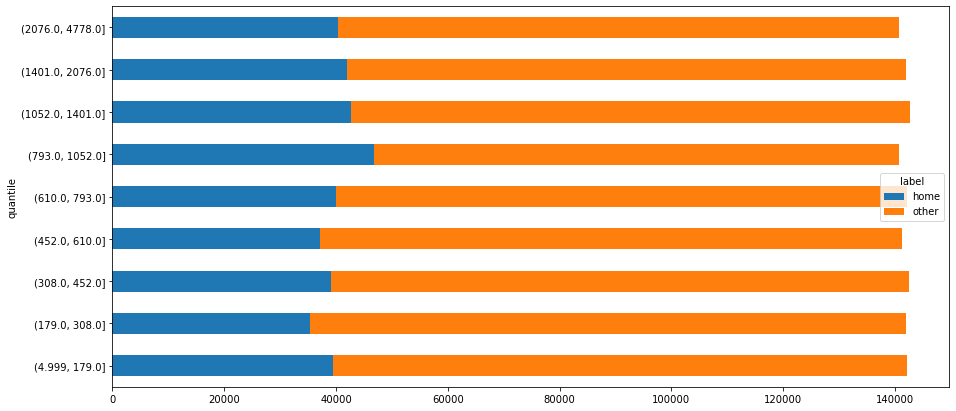

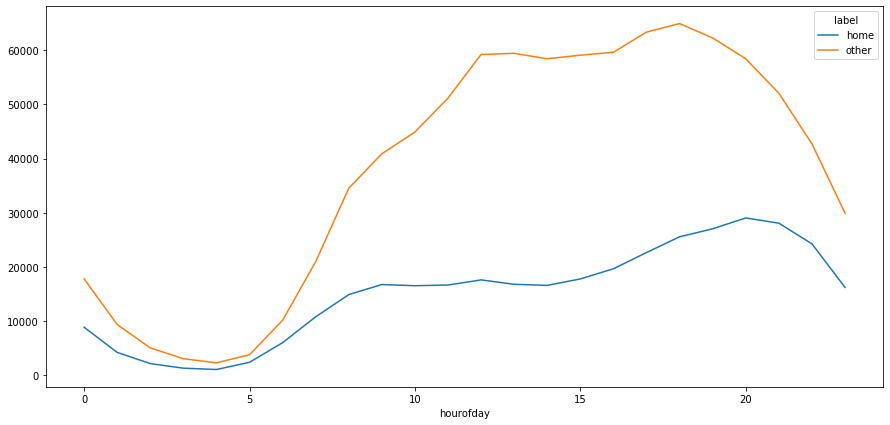

In [548]:
plot_label_distrib(regions_home)
plot_label_hourofday(regions_home)

In [825]:
def gaps(df):
    columns = ['createdat', 'region']
    df_or = df.shift(1).dropna()[columns].reset_index()
    df_ds = df.shift(-1).dropna()[columns].reset_index()
    df = df_or.join(df_ds, lsuffix="_origin", rsuffix="_destination")
    df = df.assign(duration=df['createdat_destination'] - df['createdat_origin'])
    return df

def transition_prob(df, timedlt=None, n_regions=0):
    df = gaps(df)
    if timedlt is not None:
        df = df[df['duration'] < timedlt]
    df = df[(df['region_origin'] != df['region_destination'])]
    if df.shape[0] == 0:
        print("determine transition probability: no consecutive tweets")
        return None
    indx = pandas.MultiIndex.from_product([np.arange(0, n_regions+1), np.arange(0, n_regions+1)])
    mtr = df.groupby(['region_origin', 'region_destination']).size().reindex(indx).unstack().fillna(0)
    rowsum = mtr.sum(axis=1)
    mtr[rowsum == 0] =+ 1/(n_regions+1)
    rowsum[rowsum == 0] = 1
    mtr = mtr.div(rowsum, axis=0)
    return mtr.values

def label_work(df):
    dfc = df.copy(deep=True)
    i = 0
    for uid in dfc.index.get_level_values(0).unique():
        udfc = dfc.loc[uid, :]
        udf = udfc.copy(deep=True).reset_index()
        udf = udf.sort_values('createdat')
        n_regions = udf['region'].max()
        home_region = udf[udf['label'] == 'home'].iloc[0]
        home_region = home_region['region']
        udf = udf[(udf['weekday'] < 6) & (udf['weekday'] > 0)]
        
        # Get "fake" stationary distribution
        transition_matrix = transition_prob(udf, timedlt=timedelta(hours=12), n_regions=n_regions)
        if transition_matrix is None:
            continue
        transition_matrix = transition_matrix.T
        stationary_distribution = np.linalg.matrix_power(transition_matrix, 100)[:,0]
        stationary_distribution[home_region] = 0
        work_region = stationary_distribution.argmax()
        # Set initial state to home
        #initial_state = np.zeros((transition_matrix.shape[0],1))
        #initial_state[home_region] = 1
        
        #work_probs = stationary_distribution.dot(initial_state)
        #work_probs[home_region] = 0
        #work_region = work_probs.argmax()
        dfc.loc[(uid, work_region), 'label'] = "work"
        i += 1
        if i % 100 == 0:
            print("done with {}".format(i))
    return dfc

In [810]:
regions_work = label_work(regions_home)

KeyboardInterrupt: 

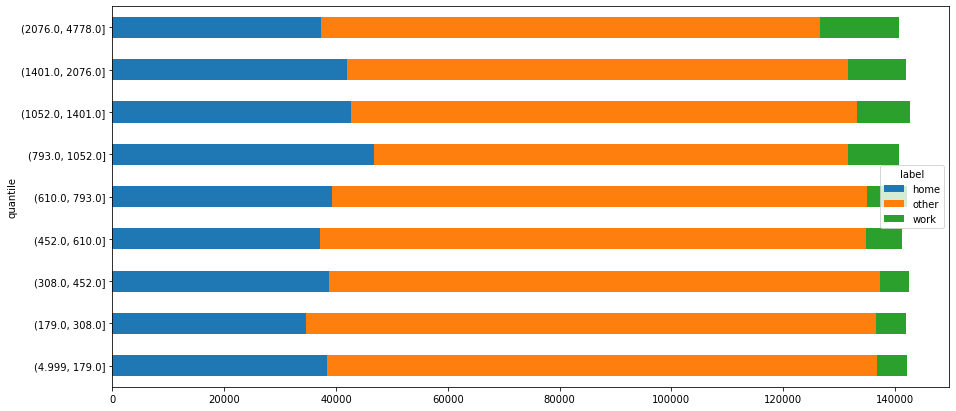

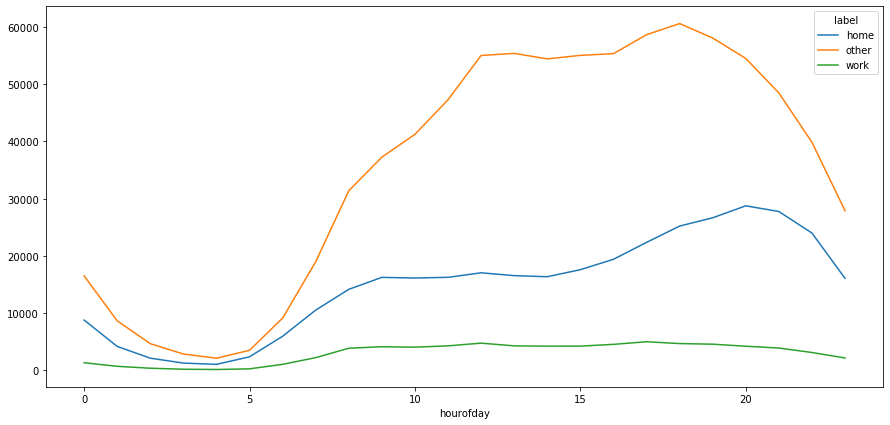

In [602]:
plot_label_distrib(regions_work)
plot_label_hourofday(regions_work)

In [603]:
regions_subset = regions[regions['userid'].isin(regions['userid'].unique()[:100])]

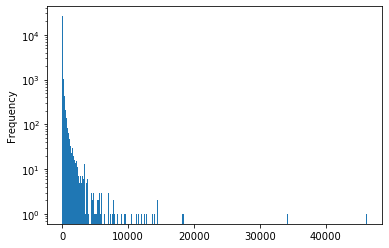

In [778]:
regions_subset.groupby('userid').apply(gaps).reset_index()['duration'].dropna().astype('timedelta64[h]').plot.hist(bins=1000, logy=True)

In [604]:
regions_subset.groupby('userid').head(1)

,userid,tweetid,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry,tweet_count,quantile,region,label
0,14153467,24287237314,2010-09-12 16:23:34+02:00,59.622270,16.503370,9.0,0.0,16.0,Europe/Stockholm,POINT (16.50337 59.62227),479,"(452.0, 610.0]",0,other
479,34262938,24291802016,2010-09-12 17:21:16+02:00,59.401982,17.987409,9.0,0.0,17.0,Europe/Stockholm,POINT (17.98741 59.40198),461,"(452.0, 610.0]",0,other
940,91627942,24297613406,2010-09-12 18:35:10+02:00,55.605118,13.024249,9.0,0.0,18.0,Europe/Stockholm,POINT (13.02425 55.60512),467,"(452.0, 610.0]",0,other
1407,11773412,24416046138,2010-09-13 17:21:37-04:00,39.942592,-75.157083,9.0,1.0,17.0,America/New_York,POINT (-75.15708 39.94259),633,"(610.0, 793.0]",0,other
2040,132646592,24464888963,2010-09-14 12:42:44+02:00,59.384057,13.471260,9.0,2.0,12.0,Europe/Stockholm,POINT (13.47126 59.38406),704,"(610.0, 793.0]",0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38992,60011262,37888279894302721,2011-02-16 15:57:24+01:00,59.320440,18.069208,2.0,3.0,15.0,Europe/Stockholm,POINT (18.06921 59.32044),80,"(4.999, 179.0]",0,other
39072,16978181,38613848302952448,2011-02-18 16:00:33+01:00,59.274700,17.910110,2.0,5.0,16.0,Europe/Stockholm,POINT (17.91011 59.27470),214,"(179.0, 308.0]",0,other
39286,194614807,40028307416293376,2011-02-22 13:41:06+01:00,58.673900,16.368629,2.0,2.0,13.0,Europe/Stockholm,POINT (16.36863 58.67390),620,"(610.0, 793.0]",0,other
39906,24664093,41116924918235136,2011-02-25 13:46:53+01:00,56.903457,14.551125,2.0,5.0,13.0,Europe/Stockholm,POINT (14.55113 56.90346),332,"(308.0, 452.0]",0,other


In [811]:
regions_subset_home = label_home(regions_subset)

copying
reindex
largest cluster
100
set values


In [607]:
regions_subset_home.loc[34262938][regions_subset_home.loc[34262938]['label'] == 'work']

,,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry,tweet_count,quantile,label
region,tweetid,,,,,,,,,,,


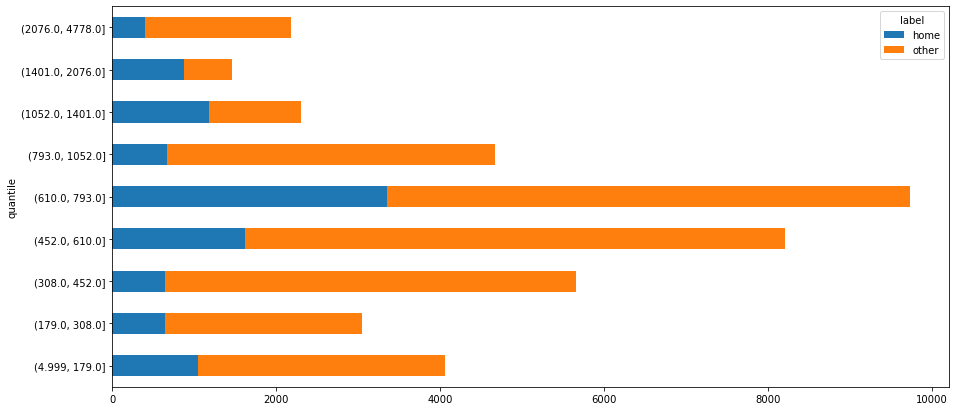

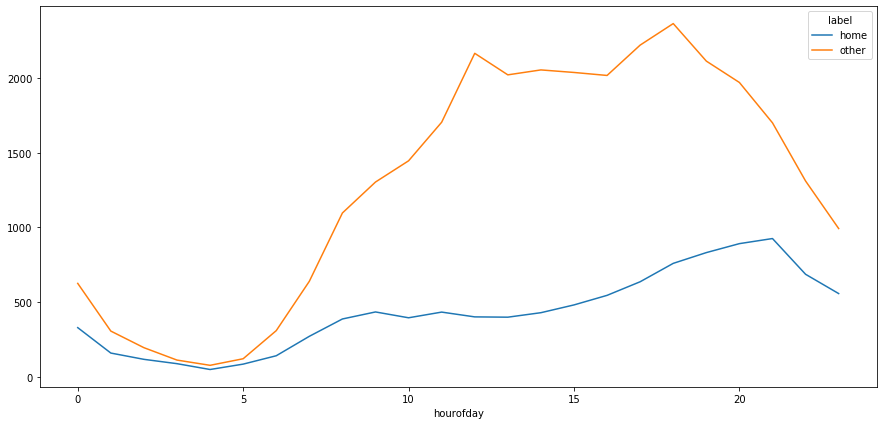

In [549]:
plot_label_distrib(regions_subset_home)
plot_label_hourofday(regions_subset_home)

In [821]:
regions_subset_work = label_work(regions_subset_home)

determine transition probability: no consecutive tweets
determine transition probability: no consecutive tweets


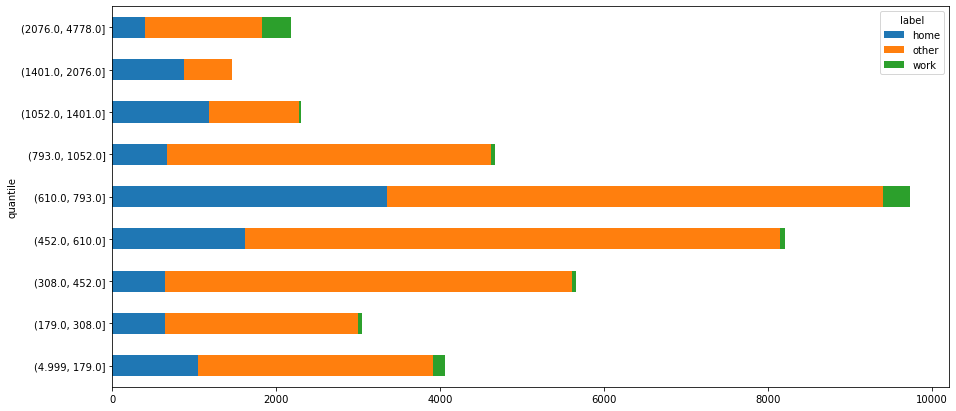

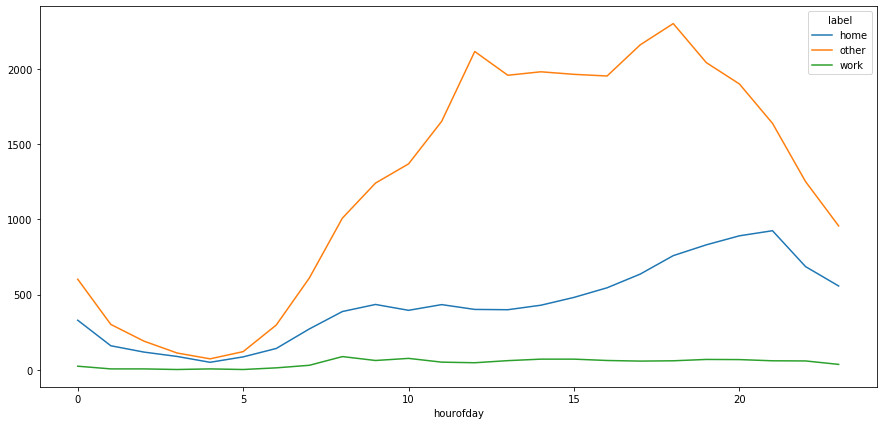

In [818]:
plot_label_distrib(regions_subset_work)
plot_label_hourofday(regions_subset_work)

In [826]:
regions_subset_work.groupby(['userid']).head(1)

,,,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry,tweet_count,quantile,label
userid,region,tweetid,,,,,,,,,,,
5040331,0,24866699613,2010-09-18 19:31:21+02:00,59.338282,18.057118,9.0,6.0,19.0,Europe/Stockholm,POINT (18.05712 59.33828),1223,"(1052.0, 1401.0]",other
7877902,0,29074978474,2010-10-29 11:37:00+01:00,51.536198,-0.106064,10.0,5.0,11.0,Europe/London,POINT (-0.10606 51.53620),263,"(179.0, 308.0]",other
8026912,0,25826524830,2010-09-29 00:34:07+02:00,59.313978,18.077409,9.0,3.0,0.0,Europe/Stockholm,POINT (18.07741 59.31398),61,"(4.999, 179.0]",other
11773412,0,24416046138,2010-09-13 17:21:37-04:00,39.942592,-75.157083,9.0,1.0,17.0,America/New_York,POINT (-75.15708 39.94259),633,"(610.0, 793.0]",other
14079762,0,13139351437320192,2010-12-10 08:54:00+01:00,59.647796,17.927005,12.0,5.0,8.0,Europe/Stockholm,POINT (17.92700 59.64780),728,"(610.0, 793.0]",other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196806894,0,19163773633822720,2010-12-26 23:52:54+01:00,59.336352,18.070837,12.0,0.0,23.0,Europe/Stockholm,POINT (18.07084 59.33635),94,"(4.999, 179.0]",other
205205058,0,22273571816472576,2011-01-04 13:50:08+01:00,59.421865,17.822526,1.0,2.0,13.0,Europe/Stockholm,POINT (17.82253 59.42187),273,"(179.0, 308.0]",home
206140202,0,29504228847,2010-11-02 21:51:07+01:00,59.384076,17.950455,11.0,2.0,21.0,Europe/Stockholm,POINT (17.95045 59.38408),64,"(4.999, 179.0]",other


In [800]:
plotly.offline.init_notebook_mode(connected=True)

230864185 = 59.40302, 17.95698


In [822]:
ts = regions_subset_work.loc[230864185]
fig = px.scatter_mapbox(ts.reset_index(), lat='latitude', lon='longitude', hover_data=['hourofday', 'weekday', 'region'], color='label')
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [824]:
u = regions_subset_work.copy(deep=True)
tp = transition_prob(u.loc[230864185, :].reset_index().sort_values('createdat'), timedlt=timedelta(hours=12), n_regions=250).T
initial_state = np.zeros((tp.shape[0],1))
initial_state[2] = 1
res = pandas.DataFrame({
    1: np.linalg.matrix_power(tp,1).dot(initial_state)[:,0],
    2: np.linalg.matrix_power(tp,2).dot(initial_state)[:,0],
    3: np.linalg.matrix_power(tp,3).dot(initial_state)[:,0],
    4: np.linalg.matrix_power(tp,4).dot(initial_state)[:,0],
    5: np.linalg.matrix_power(tp,5).dot(initial_state)[:,0],
})
res

np.linalg.matrix_power(tp,100)
                                                                                                                          

array([[0.00144959, 0.00144959, 0.00146758, ..., 0.00150477, 0.0014563 ,
        0.00144959],
       [0.00144959, 0.00144959, 0.00146758, ..., 0.00150477, 0.0014563 ,
        0.00144959],
       [0.01658307, 0.01658307, 0.0167889 , ..., 0.01721438, 0.01665984,
        0.01658307],
       ...,
       [0.00144959, 0.00144959, 0.00146758, ..., 0.00150477, 0.0014563 ,
        0.00144959],
       [0.00144959, 0.00144959, 0.00146758, ..., 0.00150477, 0.0014563 ,
        0.00144959],
       [0.00290589, 0.00290589, 0.00294196, ..., 0.00301651, 0.00291934,
        0.00290589]])

In [224]:
dfc = regions_subset_home.copy(deep=False)

In [497]:
u = dfc.loc[11773412]
u = u[(u['weekday'] < 6) & (u['weekday'] > 0)]

In [500]:
u




,region,tweetid,createdat,latitude,longitude,month,weekday,hourofday,timezone,geometry,tweet_count,quantile,label
userid,,,,,,,,,,,,,
11773412,0,24416046138,2010-09-13 17:21:37-04:00,39.942592,-75.157083,9.0,1.0,17.0,America/New_York,POINT (-75.15708 39.94259),633,"(610.0, 793.0]",other
11773412,1,24421764421,2010-09-13 18:47:41-04:00,40.124210,-74.962517,9.0,1.0,18.0,America/New_York,POINT (-74.96252 40.12421),633,"(610.0, 793.0]",other
11773412,2,24492206111,2010-09-14 12:55:10-04:00,39.949100,-75.149200,9.0,2.0,12.0,America/New_York,POINT (-75.14920 39.94910),633,"(610.0, 793.0]",other
11773412,3,24493827065,2010-09-14 13:15:57-04:00,39.950115,-75.150218,9.0,2.0,13.0,America/New_York,POINT (-75.15022 39.95012),633,"(610.0, 793.0]",other
11773412,4,24497745732,2010-09-14 14:11:58-04:00,39.952065,-75.145047,9.0,2.0,14.0,America/New_York,POINT (-75.14505 39.95207),633,"(610.0, 793.0]",other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11773412,248,1053403699131879427,2018-10-19 23:53:07+02:00,78.221149,15.644875,10.0,5.0,23.0,Arctic/Longyearbyen,POINT (15.64488 78.22115),633,"(610.0, 793.0]",other
11773412,250,1078662936241926144,2018-12-28 15:44:19+01:00,61.156020,13.203516,12.0,5.0,15.0,Europe/Stockholm,POINT (13.20352 61.15602),633,"(610.0, 793.0]",other
11773412,251,1080484596792336385,2019-01-02 16:22:56+01:00,61.161053,13.107682,1.0,3.0,16.0,Europe/Stockholm,POINT (13.10768 61.16105),633,"(610.0, 793.0]",other


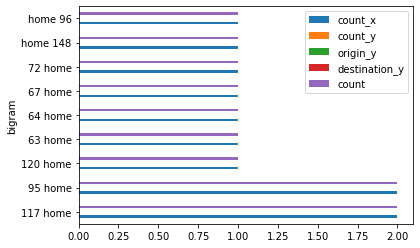

In [463]:
from datetime import timedelta
words = []
current_word = []
prev_row = None
for _, row in u.iterrows():
    if prev_row is None:
        current_word.append(str(row['region'] if row['label'] == "other" else row['label']))
    else:
        if row['createdat'] - prev_row['createdat'] < timedelta(hours=8):
            if str(row['region'] if row['label'] == "other" else row['label']) != current_word[len(current_word) - 1]:
                current_word.append(str(row['region'] if row['label'] == "other" else row['label']))
        else:
            words.append(' '.join(current_word))
            current_word = [str(row['region'] if row['label'] == "other" else row['label'])]
    prev_row = row
words.append(' '.join(current_word))
from sklearn.feature_extraction.text import CountVectorizer
vct = CountVectorizer(analyzer='word', ngram_range=(2,2), min_df=0)
freqs = vct.fit_transform(words).toarray().sum(axis=0)
bigrams = vct.get_feature_names()
seqdf = pandas.DataFrame({
    'count': freqs,
    'bigram': bigrams,
})
seqdf['origin'] = seqdf['bigram'].apply(lambda x: x.split(' ')[0])
seqdf['destination']= seqdf['bigram'].apply(lambda x: x.split(' ')[1])
seqdf2 = seqdf.copy(deep=True)
def rev(x):
    xs = x.split(' ')
    return xs[1] + " " + xs[0]
seqdf2['bigram'] = seqdf2['bigram'].apply(rev)
seqdf3 = seqdf.merge(seqdf2, on='bigram', how='left')
seqdf3['count_y'] = seqdf3['count_y'].fillna(0)
seqdf3['count'] = seqdf3['count_x'] + seqdf3['count_y']
seqdf3[seqdf3['count_x'] != seqdf3['count_y']]
seqdf3[(seqdf3['origin_x'] == 'home') | (seqdf3['destination_x'] == 'home') ].sort_values('count', ascending=False).set_index('bigram').head(10).plot(kind='barh')